In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import seaborn as sns
J = os.path.join

root = J(os.environ["DATASET_ROOT"], "bcd2022", "images_512")

In [2]:
df = pd.read_csv(J("data","train.csv"))
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [6]:
df["density"] = df["density"].fillna("N")

<AxesSubplot: xlabel='density', ylabel='count'>

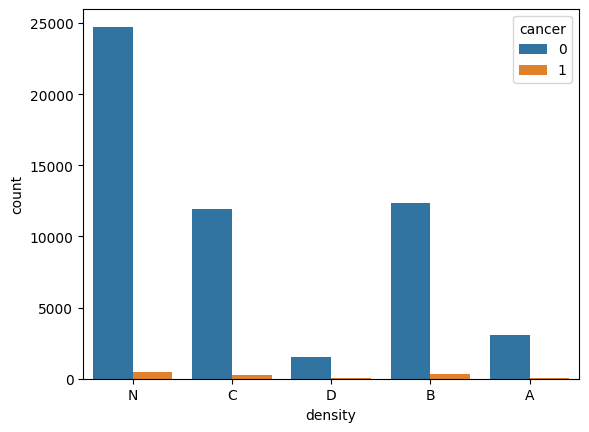

In [7]:
sns.countplot(data=df, x="density", hue="cancer")

<AxesSubplot: xlabel='BIRADS', ylabel='count'>

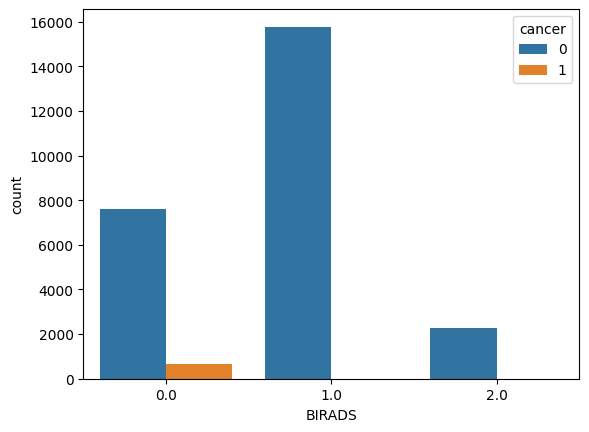

In [74]:
sns.countplot(data=df, x="BIRADS", hue="cancer")

In [52]:
from sklearn.preprocessing import LabelEncoder

df1 = df[df["density"]!="N"]
df1.index = np.arange(len(df1))


le = LabelEncoder()
df1.loc[:, "density"] = le.fit_transform(df1["density"])

le = LabelEncoder()
df1.loc[:, "view"] = le.fit_transform(df1["view"])



/tmp/ipykernel_8811/1085478566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, "density"] = le.fit_transform(df1["density"])
/tmp/ipykernel_8811/1085478566.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df1.loc[:, "density"] = le.fit_transform(df1["density"])
/tmp/ipykernel_8811/1085478566.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

# LGBM

In [53]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

df1_train, df1_val = train_test_split(df1, random_state=42, shuffle=True)

In [128]:
params = {
    'is_unbalance': 'true', # replaced with scale_pos_weight argument

}

In [129]:
cols = ["invasive"]

X_train = df1_train[cols].values
y_train = df1_train["cancer"].values
X_val = df1_val[cols].values
y_val = df1_val["cancer"].values

In [130]:
cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='multi_logloss', verbose=False)
y_proba = cls.predict_proba(X_val)
prec, rec, thr = precision_recall_curve(y_val, y_proba[:,1])
f1 = 2*prec*rec/(prec+rec)
f1[np.isnan(f1)] = 0
max_i = np.argmax(f1)
print("Prec",prec[max_i])
print("Rec", rec[max_i])
print("F1", f1[max_i])
print("thr", thr[max_i])

/home/alenic/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Prec 1.0
Rec 0.6918918918918919
F1 0.817891373801917
thr 0.9996943427392095
